In [ ]:

import cv2
from skimage.transform import resize
from models.Unet import UNet
from dataset.data import BatchMaker
from utils.metrics import SegmentationMetrics
from utils.augmentation import MyAugmentation
import torch
import yaml
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
BATCH = 3
path_to_config = '/media/cal314-1/9E044F59044F3415/Marcin/noisy_labels/Kod/config/config_lab.yaml'
with open(path_to_config, 'r') as config_file:
    config = yaml.safe_load(config_file)
model_path = config['save_model_path'] + '/mixedGT1_best_model'


annotator1 = BatchMaker(config_path=path_to_config, batch_size=BATCH, mode = 'train',segment = 'intersection_and_union',annotator= 1)
train_GT1 = annotator1.train_loader

In [ ]:
def display_multiclass_mask(mask, colors):
    """
    Funkcja do wyświetlania wieloklasowej maski jako obrazu RGB.
    
    :param mask: Maska z klasami jako różne warstwy.
    :param colors: Kolory odpowiadające każdej klasie.
    """
    # Usunięcie ewentualnego dodatkowego wymiaru
    if mask.shape[0] == 1:
        mask = mask.squeeze(0)
    
    # Inicjalizacja obrazu RGB
    rgb_image = np.zeros((*mask.shape[:2], 3), dtype=np.uint8)
    
    # Iteracja przez każdą klasę i kolorowanie odpowiednich pikseli
    for class_id, color in enumerate(colors):
        # Ustawianie kolorów tam, gdzie maska klasy jest aktywna
        rgb_image[mask[:, :, class_id] == 1] = color
    
    # Wyświetlanie obrazu
    plt.imshow(rgb_image)
    plt.axis('off')  # Usunięcie osi dla lepszego wyświetlania
    plt.show()


In [ ]:
from utils.augmentation import MyAugmentation
colors = [[0, 0, 0], [0, 255, 0], [255, 0, 0]]  # tło, wić, główka
# Utwórz obraz RGB z maski


for batch_idx, (inputs, intersections,unions) in enumerate(train_GT1):
    #if batch_idx == 0:
        #intersections = intersections.permute(0,3,1,2)
        #unions = unions.permute(0,3,1,2)
    if batch_idx == 1:
        break

    #augmentation = MyAugmentation()
    #for j in range(inputs.shape[0]):
        #inputs[j],intersections[j] = augmentation(inputs[j],intersections[j])    



    mask_to_display = unions[2].numpy().transpose(1, 2, 0)
    mask_to_display2 = intersections[2].numpy().transpose(1, 2, 0)
    mask_to_display3 = mask_to_display - mask_to_display2
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(inputs[2].numpy().transpose(1, 2, 0))
    plt.axis('off')  
    plt.subplot(1, 2, 2)
    display_multiclass_mask(mask_to_display3, colors)

 


In [ ]:
import cv2

input = cv2.imread('/home/nitro/Studia/Praca Dyplomowa/noisy_labels/Dataset/SegSperm/train/GT1_full/0.png')
input = cv2.cvtColor(input, cv2.COLOR_BGR2RGB)

In [ ]:
import cv2
from skimage.transform import resize
from models.Unet import UNet
from dataset.data import BatchMaker
from utils.metrics import SegmentationMetrics
from utils.better_aug import BetterAugmentation
import torch
import yaml
import numpy as np
import matplotlib.pyplot as plt
import random

def rgb_to_class_id(mask_rgb, class_colors):
        mask_id = np.zeros((*mask_rgb.shape[:2], len(class_colors)), dtype=np.float32)
        for class_id, color in enumerate(class_colors):
            idx = class_id
            if class_id == 3:
                idx = 1
                mask = (mask_rgb == color).all(axis=2).astype(np.float32)
                mask_id[:, :, -1] = np.logical_or(mask_id[:, :, -1], mask)
            else:
                mask = (mask_rgb == color).all(axis=2).astype(np.float32)
                mask_id[:, :, idx] = mask

            if idx == 1 or idx == 2:
                mask_id[:, :, -1] = np.logical_or(mask_id[:, :, -1], mask)

        return mask_id

class_colors = [[0, 0, 0], [0, 255, 0], [0, 0, 255],[0,255,255]]  # tło, wić, główka
number = random.randint(0, 431)
print(f'Number = {number}')
number = 14

img = cv2.imread(f'/media/cal314-1/9E044F59044F3415/Marcin/noisy_labels/Dataset/SegSperm/test/images/{number}.png')
x_img = img.astype(np.float32)
x_img = resize(x_img, (512, 512, 3), mode='constant', preserve_range=True)


        
# Load masks
mask = cv2.imread(f'/media/cal314-1/9E044F59044F3415/Marcin/noisy_labels/Dataset/SegSperm/test/GT1_mixed/{number}.png')
mask = mask.astype(np.float32)
mask = resize(mask, (512, 512, 3), mode='constant', preserve_range=True)
mask_id = rgb_to_class_id(mask, class_colors)

hmask = cv2.imread(f'/media/cal314-1/9E044F59044F3415/Marcin/noisy_labels/Dataset/SegSperm/test/GT1_head/{number}.png')
hmask = mask.astype(np.float32)
hmask = resize(hmask, (512, 512, 1), mode='constant', preserve_range=True)
#hmask_id = rgb_to_class_id(hmask, class_colors)
min_val = np.min(x_img)
max_val = np.max(x_img)
x_img = (x_img - min_val) / (max_val - min_val)


x_img = x_img.transpose(2, 0, 1)
mask_id = mask_id.transpose(2, 0, 1)
x_img = torch.from_numpy(x_img)
mask_id = torch.from_numpy(mask_id)


augmentation = BetterAugmentation()
input = x_img.unsqueeze(0)
x_img,mask_id = augmentation(x_img,mask_id)

mask_id = mask_id.unsqueeze(0)
mask_id = mask_id.numpy().transpose(0, 2, 3, 1)
mask_to_display = mask_id[0]

colors = [[0, 0, 0], [0, 255, 0], [255, 0, 0]]  # tło, wić, główka

# Utwórz obraz RGB z maski
mask_rgb = np.zeros((mask_to_display.shape[0], mask_to_display.shape[1], 3), dtype=np.uint8)
for class_id, color in enumerate(colors):
    mask_rgb[mask_to_display[:, :, class_id] == 1] = color
    
    
kernel = np.ones((3, 3), np.uint8)    
mask_rgb = cv2.morphologyEx(mask_rgb, cv2.MORPH_CLOSE, kernel)



plt.figure(figsize=(5, 5))
plt.imshow(x_img[0].permute(1,2,0))
plt.axis('off')
plt.show()
output = x_img[0].permute(1,2,0).numpy()

plt.figure(figsize=(5, 5))
plt.imshow(input[0].permute(1,2,0))
plt.axis('off')



plt.figure(figsize=(50, 50))
plt.subplot(1,3,1)
plt.axis('off')
plt.imshow(x_img[0].permute(1,2,0))
plt.subplot(1,3,2)
plt.axis('off')
plt.imshow(mask_rgb)
plt.subplot(1,3,3)
plt.axis('off')
plt.imshow(mask)
plt.show()


cv2.imwrite('/media/cal314-1/9E044F59044F3415/Marcin/noisy_labels/example.png',output*255)





In [ ]:
import cv2
from skimage.transform import resize
from models.Unet import UNet
from dataset.data import BatchMaker
from utils.metrics import SegmentationMetrics
from utils.augmentation import MyAugmentation
import torch
import yaml
import numpy as np
import matplotlib.pyplot as plt
import random

def rgb_to_class_id(mask_rgb, class_colors):
        mask_id = np.zeros(mask_rgb.shape[:2], dtype=np.float32)
        for class_id, color in enumerate(class_colors):
            idx = class_id
            if class_id == 3:
                idx = 1
            mask_id[(mask_rgb == color).all(axis=2)] = idx
        return mask_id

class_colors = [[0, 0, 0], [0, 255, 0], [0, 0, 255],[0,255,255]]  # tło, wić, główka
number = random.randint(0, 431)
print(f'Number = {number}')

img = cv2.imread(f'/media/cal314-1/9E044F59044F3415/Marcin/noisy_labels/Dataset/SegSperm/train/images/{number}.png')
x_img = img.astype(np.float32)
x_img = resize(x_img, (512, 512, 3), mode='constant', preserve_range=True)

min_val = np.min(x_img)
max_val = np.max(x_img)
x_img = (x_img - min_val) / (max_val - min_val)
        
# Load masks
#GT1_mixed
mask1 = cv2.imread(f'/media/cal314-1/9E044F59044F3415/Marcin/noisy_labels/Dataset/SegSperm/train/GT1_mixed/{number}.png')
mask1 = mask1.astype(np.float32)
mask1 = resize(mask1, (512, 512, 3), mode='constant', preserve_range=True)
mask_id_1 = rgb_to_class_id(mask1, class_colors)
#GT2_mixed
mask2 = cv2.imread(f'/media/cal314-1/9E044F59044F3415/Marcin/noisy_labels/Dataset/SegSperm/train/GT2_mixed/{number}.png')
mask2 = mask2.astype(np.float32)
mask2 = resize(mask2, (512, 512, 3), mode='constant', preserve_range=True)
mask_id_2 = rgb_to_class_id(mask2, class_colors)

plt.figure(figsize=(15, 15))
plt.subplot(1,2,1)
plt.imshow(mask_id_1)
plt.subplot(1,2,2)
plt.imshow(mask_id_2)
plt.axis('off')


intersection = cv2.bitwise_and(mask1, mask2)
union = cv2.bitwise_or(mask1, mask2)

intersection_id = rgb_to_class_id(intersection, class_colors)
union_id = rgb_to_class_id(union, class_colors)


colors = [[0, 0, 0], [0, 255, 0], [255, 0, 0]]  # tło, wić, główka
# Utwórz obraz RGB z maski
mask_to_display = intersection_id
intersection_rgb = np.zeros((mask_to_display.shape[0], mask_to_display.shape[1], 3), dtype=np.uint8)
for i, color in enumerate(colors):
    intersection_rgb[mask_to_display == i] = color

mask_to_display = union_id
union_rgb = np.zeros((mask_to_display.shape[0], mask_to_display.shape[1], 3), dtype=np.uint8)
for i, color in enumerate(colors):
    union_rgb[mask_to_display == i] = color
    

plt.figure(figsize=(15, 15))
plt.subplot(1,2,1)
plt.imshow(intersection_rgb)
plt.subplot(1,2,2)
plt.imshow(union_rgb)
plt.axis('off')


plt.figure(figsize=(15, 15))
plt.subplot(1,2,1)
plt.imshow(intersection)
plt.subplot(1,2,2)
plt.imshow(union)
plt.axis('off')




In [ ]:
import torch
import torch.nn as nn

# Załóżmy, że weights to tensor o długości równej liczbie klas, tutaj 4.
# Dla przykładu, wszystkie wagi ustawione są na 1. Możesz je dostosować w zależności od potrzeb.
weights = torch.ones([4,512,512])
weights[0] = 0.1 
weights[1] = 0.7
weights[2] = 0.4
weights[3] = 0.4

# Utwórz funkcję straty z pos_weight
loss_fn = nn.BCEWithLogitsLoss(weight=weights)

# Zakładając, że output i ids mają wymiary [22, 4, 512, 512], jak wspomniano
output = torch.randn(22, 4, 512, 512)  # Przykładowy tensor wyjściowy modelu
ids = torch.empty(22, 4, 512, 512).random_(2).float()  # Przykładowy tensor docelowy

# Oblicz stratę
loss = loss_fn(output, ids)
print(loss)

In [ ]:
target = torch.ones([10, 64,512,512], dtype=torch.float32)  # 64 classes, batch size = 10
output = torch.full([10, 64,512,512], 1.5)  # A prediction (logit)
pos_weight = torch.ones([64])  # All weights are equal to 1
criterion = torch.nn.BCEWithLogitsLoss(weight=pos_weight)
criterion(output, target)  # -log(sigmoid(1.5))

In [ ]:
import numpy as np

def check_if_multiclass(mask):
    unique_values = np.unique(mask)
    # Zakładamy, że wartość 0 reprezentuje tło
    # Sprawdzamy, czy jest więcej niż jedna wartość oprócz tła
    return len(unique_values[unique_values != 0]) > 1

def perform_operation_if_multiclass(mask):
    if check_if_multiclass(mask):
        print("Maska jest wieloklasowa, wykonuję operację...")
        # Tutaj wykonaj odpowiednią operację
    else:
        print("Maska nie jest wieloklasowa.")

# Przykładowe maski
mask_single_class = np.zeros((512, 512))
mask_single_class[100:200, 100:200] = 1  # Maska z jedną klasą
mask_multi_class[300:400, 300:400] = 0  # Maska z dwoma klasami

mask_multi_class = np.zeros((512, 512))
mask_multi_class[100:200, 100:200] = 1
mask_multi_class[300:400, 300:400] = 2  # Maska z dwoma klasami

# Sprawdzanie i wykonanie operacji
perform_operation_if_multiclass(mask_single_class)
perform_operation_if_multiclass(mask_multi_class)

In [ ]:
import matplotlib.pyplot as plt
import torch

soft1 = torch.softmax(output1,dim=1)
soft2 = torch.softmax(output2,dim=2)

thresholds = torch.linspace(0, 1, steps=100)  
iou_scores = []

for threshold in thresholds:
    pred_masks = (soft2 > threshold).float() 
    iou = calculate_iou(pred_masks, ids2)
    iou_scores.append(iou)


optimal_threshold = thresholds[torch.argmax(torch.tensor(iou_scores))]
optimal_iou = max(iou_scores)

print(f"Optimal threshold: {optimal_threshold}")
print(f"Optimal IoU: {optimal_iou}")

In [20]:
from PIL import Image
import os

# Lista ścieżek do folderów, które zawierają zdjęcia
folders = ['/media/cal314-1/9E044F59044F3415/Marcin/noisy_labels/Dataset/SegSperm/test/For testing/images',
           

'/media/cal314-1/9E044F59044F3415/Marcin/noisy_labels/Dataset/SegSperm/test/For testing/GT', 
           
           
'/media/cal314-1/9E044F59044F3415/Marcin/Data/softmasks/Annotator_1_Model_smpUNet++_Augmentation_True_Modemulticlass_Optimizer_Adam_Scheduler_CosineAnnealingLR_Epochs_300_Batch_Size_6_Start_lr_0.001_Loss_CrossEntropyLoss_Timestamp_2024-04-27-18-20_best_model_iou_multiclass_/masks/best_tresholds_multiclass', 
           
           
'/media/cal314-1/9E044F59044F3415/Marcin/Data/softmasks/Annotator_1_Model_smpUNet++_Augmentation_True_Modemulticlass_Optimizer_Adam_Scheduler_CosineAnnealingLR_Epochs_300_Batch_Size_6_Start_lr_0.001_Loss_CrossEntropyLoss_Timestamp_2024-04-27-18-20_best_model_iou_multiclass_/multiclass',
           
]

# Folder docelowy do zapisu połączonych zdjęć
output_folder = '/media/cal314-1/9E044F59044F3415/Marcin/Vis'
os.makedirs(output_folder, exist_ok=True)

# Znalezienie wspólnych plików w wszystkich folderach
common_files = set(os.listdir(folders[0]))
for folder in folders[1:]:
    common_files.intersection_update(os.listdir(folder))

# Przetwarzanie każdego wspólnego pliku
for filename in common_files:
    if filename.endswith(('.png', '.jpg', '.jpeg')):  # Sprawdzenie czy plik to obraz
        images = [Image.open(os.path.join(folder, filename)) for folder in folders if os.path.exists(os.path.join(folder, filename))]

        # Znalezienie maksymalnej wysokości i sumarycznej szerokości
        max_height = max(img.height for img in images)
        total_width = sum(img.width for img in images)
        

        # Skalowanie obrazów do tej samej wysokości i tworzenie nowego obrazu o odpowiedniej szerokości
        new_im = Image.new('RGB', (total_width, max_height))
        x_offset = 0
        for img in images:
            # Skalowanie obrazu, jeśli to konieczne
            new_im.paste(img, (x_offset, 0))
            x_offset += img.width

        # Zapisanie połączonego obrazu
        new_im.save(os.path.join(output_folder, filename))

print("Zakończono łączenie zdjęć.")


Zakończono łączenie zdjęć.


In [ ]:
import segmentation_models_pytorch as smp

model = smp.UnetPlusPlus(in_channels = 3, classes=3,encoder_name="resnet18",encoder_weights=None)

print(model)

In [ ]:
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]}")

In [ ]:
# Dla wag
for name, param in model.named_parameters():
    if 'weight' in name:
        print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]}")

# Dla bias
for name, param in model.named_parameters():
    if 'bias' in name:
        print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]}")

In [ ]:
import torch.nn as nn

def count_conv_layers(model):
    count = 0
    for module in model.modules():
        if isinstance(module, nn.Conv2d):
            count += 1
    return count


num_conv_layers = count_conv_layers(model)
print(f"Liczba warstw konwolucyjnych: {num_conv_layers}")

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Load the image
image_path = "/media/cal314-1/9E044F59044F3415/Marcin/results/Marcin_Annotator_1_Model_smpUNet++_Augmentation_True_Modemulticlass_Optimizer_Adam_Scheduler_CosineAnnealingLR_Epochs_200_Batch_Size_6_Start_lr_0.001_Loss_CrossEntropyLoss_Timestamp_2024-04-21-19-25_best_model_iou_multiclass_/masks/best_tresholds_multiclass/0.png"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Perform morphological closing
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
closing = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)

# Display the original image and the result
plt.figure(figsize=(30, 15))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(closing, cmap='gray')
plt.title('Image after Morphological Closing')
plt.axis('off')

plt.show()

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def load_masks_from_paths(paths):
    """
    Wczytuje maski z podanych ścieżek do obrazów.

    :param paths: Lista ścieżek do obrazów.
    :return: Lista masek binarnych.
    """
    masks = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in paths]
    return masks

def display_masks(masks, colors):
    assert len(masks) == len(colors), "Liczba masek musi być równa liczbie kolorów."
    rgb_image = np.zeros((*masks[0].shape, 3), dtype=np.uint8)
    for mask, color in zip(masks, colors):
        rgb_image[mask == 255] = color
    plt.imshow(rgb_image)
    plt.axis('off')
    plt.show()

# Przykładowe ścieżki do obrazów
paths = ['/media/cal314-1/9E044F59044F3415/Marcin/Data/softmasks/Annotator_1_Model_smpUNet++_Augmentation_True_Modemulticlass_Optimizer_Adam_Scheduler_CosineAnnealingLR_Epochs_300_Batch_Size_6_Start_lr_0.001_Loss_CrossEntropyLoss_Timestamp_2024-04-27-18-20_best_model_iou_multiclass_/masks/best_tresholds_oneclass/0.png', 
         
 '/media/cal314-1/9E044F59044F3415/Marcin/Data/softmasks/Annotator_1_Model_smpUNet++_Augmentation_True_Modeoneclass_Optimizer_Adam_Scheduler_CosineAnnealingLR_Epochs_200_Batch_Size_6_Start_lr_0.001_Loss_CrossEntropyLoss_Timestamp_2024-04-22-10-14_best_model_ap_oneclass_/masks/best_tresholds_oneclass/0.png', 
         
 # '/media/cal314-1/9E044F59044F3415/Marcin/Data/softmasks/Annotator_1_Model_smpUNet++_Augmentation_True_Modemulticlass_Optimizer_Adam_Scheduler_CosineAnnealingLR_Epochs_300_Batch_Size_6_Start_lr_0.001_Loss_CrossEntropyLoss_Timestamp_2024-04-27-18-20_best_model_iou_multiclass_/masks/best_tresholds_tail/0.png'
         
         ]

# Przykładowe kolory (RGB)
colors = [[255, 0, 0], [0, 255, 0]]

# Wczytanie masek i wyświetlenie
masks = load_masks_from_paths(paths)
display_masks(masks, colors)

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def rgb_to_binary_mask(rgb_image_path):
    # Wczytanie obrazu RGB
    rgb_image = Image.open(rgb_image_path)
    # Konwersja na tablicę numpy
    rgb_array = np.array(rgb_image)
    # Wymiary obrazu
    height, width, _ = rgb_array.shape
    # Inicjalizacja maski binarnej
    binary_mask = np.zeros((height, width), dtype=np.uint8)

    # Iteracja po każdym pikselu obrazu
    for y in range(height):
        for x in range(width):
            # Jeśli piksel nie jest czarny, oznacz jako 1
            if not np.array_equal(rgb_array[y, x], [0, 0, 0]):
                binary_mask[y, x] = 1

    return binary_mask


# Wczytanie obrazu
image_path = '/media/cal314-1/9E044F59044F3415/Marcin/Data/softmasks/Annotator_1_Model_smpUNet++_Augmentation_True_Modemulticlass_Optimizer_Adam_Scheduler_CosineAnnealingLR_Epochs_300_Batch_Size_6_Start_lr_0.001_Loss_CrossEntropyLoss_Timestamp_2024-04-27-18-20_best_model_iou_multiclass_/masks/best_tresholds_multiclass/0.png'
image = cv2.imread(image_path)

image2 = rgb_to_binary_mask(image_path)
# Wyświetlenie oryginalnego obrazu i obrazu po konwersji
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image2, cmap='gray')
plt.title('Converted Image')
plt.axis('off')

plt.show()

In [ ]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Wczytaj wszystkie zdjęcia



def generate_difference_mask(gt_image_path, predicted_mask_path):
    # Wczytaj obrazy GT i maski przewidywanej przez model
    gt_image = cv2.imread(gt_image_path, cv2.IMREAD_GRAYSCALE)
    predicted_mask = cv2.imread(predicted_mask_path, cv2.IMREAD_GRAYSCALE)

    # Inicjalizuj pustą maskę różnic
    difference_mask = np.zeros((gt_image.shape[0], gt_image.shape[1], 3), dtype=np.uint8)

    # TP - obszary, które są poprawnie sklasyfikowane jako obiekty
    difference_mask[(gt_image == 255) & (predicted_mask == 255)] = [255, 0, 0]  # Czerwony

    # FP - obszary, które są błędnie sklasyfikowane jako obiekty
    difference_mask[(gt_image == 0) & (predicted_mask == 255)] = [0, 255, 0]  # Zielony

    # FN - obszary, które są błędnie sklasyfikowane jako tło
    difference_mask[(gt_image == 255) & (predicted_mask == 0)] = [0, 0, 255]  # Niebieski

    # TN - obszary, które są poprawnie sklasyfikowane jako tło
    difference_mask[(gt_image == 0) & (predicted_mask == 0)] = [0, 0, 0]  # Biały

    return difference_mask


def generate_difference_mask2(gt_image_path, predicted_mask):
    # Wczytaj obrazy GT i maski przewidywanej przez model
    gt_image = cv2.imread(gt_image_path, cv2.IMREAD_GRAYSCALE)
  

    # Inicjalizuj pustą maskę różnic
    difference_mask = np.zeros((gt_image.shape[0], gt_image.shape[1], 3), dtype=np.uint8)

    # TP - obszary, które są poprawnie sklasyfikowane jako obiekty
    difference_mask[(gt_image == 255) & (predicted_mask == 255)] = [255, 0, 0]  # Czerwony

    # FP - obszary, które są błędnie sklasyfikowane jako obiekty
    difference_mask[(gt_image == 0) & (predicted_mask == 255)] = [0, 255, 0]  # Zielony

    # FN - obszary, które są błędnie sklasyfikowane jako tło
    difference_mask[(gt_image == 255) & (predicted_mask == 0)] = [0, 0, 255]  # Niebieski

    # TN - obszary, które są poprawnie sklasyfikowane jako tło
    difference_mask[(gt_image == 0) & (predicted_mask == 0)] = [0, 0, 0]  # Biały

    return difference_mask



number = 3

image_paths = [f"/media/cal314-1/9E044F59044F3415/Marcin/noisy_labels/Dataset/SegSperm/test/For testing/images/{number}.png",
               
               f"/media/cal314-1/9E044F59044F3415/Marcin/noisy_labels/Dataset/SegSperm/test/For testing/GT/{number}.png", 
               
               f"/media/cal314-1/9E044F59044F3415/Marcin/results/Emilia_Annotator_1_Model_smpUNet++_Augmentation_True_Modeoneclass_Optimizer_Adam_Scheduler_CosineAnnealingLR_Epochs_200_Batch_Size_6_Start_lr_0.001_Loss_CrossEntropyLoss_Timestamp_2024-04-20-19-01_best_model_ap_oneclass_/{number}.png", 
               
               f"/media/cal314-1/9E044F59044F3415/Marcin/results/Marcin_Annotator_1_Model_smpUNet++_Augmentation_True_Modeoneclass_Optimizer_Adam_Scheduler_CosineAnnealingLR_Epochs_300_Batch_Size_6_Start_lr_0.001_Loss_CrossEntropyLoss_Timestamp_2024-04-27-18-20_best_model_iou_oneclass_/{number}.png",
               
               f"/media/cal314-1/9E044F59044F3415/Marcin/results/Emilia_Annotator_1_Model_smpUNet++_Augmentation_True_Modemulticlass_Optimizer_Adam_Scheduler_CosineAnnealingLR_Epochs_200_Batch_Size_6_Start_lr_0.001_Loss_CrossEntropyLoss_Timestamp_2024-04-21-16-30_best_model_ap_oneclass_/multiclass/{number}.png",
               
               f"/media/cal314-1/9E044F59044F3415/Marcin/results/Marcin_Annotator_1_Model_smpUNet++_Augmentation_True_Modemulticlass_Optimizer_Adam_Scheduler_CosineAnnealingLR_Epochs_300_Batch_Size_6_Start_lr_0.001_Loss_CrossEntropyLoss_Timestamp_2024-04-27-18-20_best_model_iou_multiclass_/multiclass/{number}.png"
               
               
               ]


mask_paths = [
                f"/media/cal314-1/9E044F59044F3415/Marcin/noisy_labels/Dataset/SegSperm/test/For testing/images/{number}.png",
               
               f"/media/cal314-1/9E044F59044F3415/Marcin/noisy_labels/Dataset/SegSperm/test/For testing/GT/{number}.png", 
               
               f"/media/cal314-1/9E044F59044F3415/Marcin/results/Emilia_Annotator_1_Model_smpUNet++_Augmentation_True_Modeoneclass_Optimizer_Adam_Scheduler_CosineAnnealingLR_Epochs_200_Batch_Size_6_Start_lr_0.001_Loss_CrossEntropyLoss_Timestamp_2024-04-20-19-01_best_model_ap_oneclass_/masks/best_tresholds_oneclass/{number}.png", 
               
               f"/media/cal314-1/9E044F59044F3415/Marcin/results/Marcin_Annotator_1_Model_smpUNet++_Augmentation_True_Modeoneclass_Optimizer_Adam_Scheduler_CosineAnnealingLR_Epochs_300_Batch_Size_6_Start_lr_0.001_Loss_CrossEntropyLoss_Timestamp_2024-04-27-18-20_best_model_iou_oneclass_/masks/best_tresholds_oneclass/{number}.png",
               
               f"/media/cal314-1/9E044F59044F3415/Marcin/results/Emilia_Annotator_1_Model_smpUNet++_Augmentation_True_Modemulticlass_Optimizer_Adam_Scheduler_CosineAnnealingLR_Epochs_200_Batch_Size_6_Start_lr_0.001_Loss_CrossEntropyLoss_Timestamp_2024-04-21-16-30_best_model_ap_oneclass_/masks/best_tresholds_multiclass/{number}.png",
               
               f"/media/cal314-1/9E044F59044F3415/Marcin/results/Marcin_Annotator_1_Model_smpUNet++_Augmentation_True_Modemulticlass_Optimizer_Adam_Scheduler_CosineAnnealingLR_Epochs_300_Batch_Size_6_Start_lr_0.001_Loss_CrossEntropyLoss_Timestamp_2024-04-27-18-20_best_model_iou_multiclass_/masks/best_tresholds_multiclass/{number}.png"
               
               
               ]

images = [cv2.imread(img_path) for img_path in image_paths]
masks = [cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) for mask_path in mask_paths]

# Ustaw siatkę o wymiarach 2x3 z większym polem dla pierwszego zdjęcia
fig = plt.figure(figsize=(24, 7))
gs = gridspec.GridSpec(2, 6, width_ratios=[2, 1, 1,1,1,1], height_ratios=[0.9, 0.9])

# Ustaw pierwsze zdjęcie na większej części w siatce
plt.rcParams['font.size'] = 15
ax0 = plt.subplot(gs[:, 0])
if images:
    ax0.imshow(cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB))
    ax0.set_title("Image", loc='center', pad=-10)
    ax0.axis('off')

    

    # Ustaw pozostałe zdjęcia w pierwszym wierszu
    for i in range(1, min(len(images), 6)):
        ax = plt.subplot(gs[0, i])
        ax.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        if i == 1:
            ax.set_title(f"Ground truth", loc='center', pad=-10)
        elif i == 2:
            ax.set_title(f"Object segmentation", loc='center', pad=-10)
        elif i == 3:
            ax.set_title(f"Object segmentation\n+\naugmentation", loc='center', pad=-10)
        elif i == 4:
            ax.set_title(f"Part segmentation", loc='center', pad=-10)
        elif i == 5:
            ax.set_title(f"Part segmentation\n+\naugmentation", loc='center', pad=-10)
        #ax.set_title(f"Obraz {i}", loc='center', pad=10)
        ax.axis('off')
    # Ustaw pozostałe zdjęcia w drugim wierszu
    for i in range(1, min(len(images), 6)):
        ax = plt.subplot(gs[1, i])
        
        if i == 4 or i == 5:
            masks[i] = rgb_to_binary_mask(mask_paths[i])
            difference_mask = generate_difference_mask2(mask_paths[1], masks[i]*255)
            ax.imshow(difference_mask)
        else:
            masks[i] = cv2.cvtColor(masks[i], cv2.COLOR_BGR2RGB)
            difference_mask = generate_difference_mask(mask_paths[1], mask_paths[i])
            ax.imshow(difference_mask)
       
        if i == 1:
            ax.set_title(f"Difference mask", loc='center', pad=-10)
        elif i == 2:
            ax.set_title(f"Difference mask", loc='center', pad=-10)
        elif i == 3:
            ax.set_title(f"Difference mask", loc='center', pad=-10)
        elif i == 4:
            ax.set_title(f"Difference mask", loc='center', pad=-10)
        elif i == 5:
            ax.set_title(f"Difference mask", loc='center', pad=-10)
        ax.axis('off')

    # Wyświetl siatkę
    plt.tight_layout()
    plt.show()
else:
    print("Brak poprawnie wczytanych obrazów do wyświetlenia.")


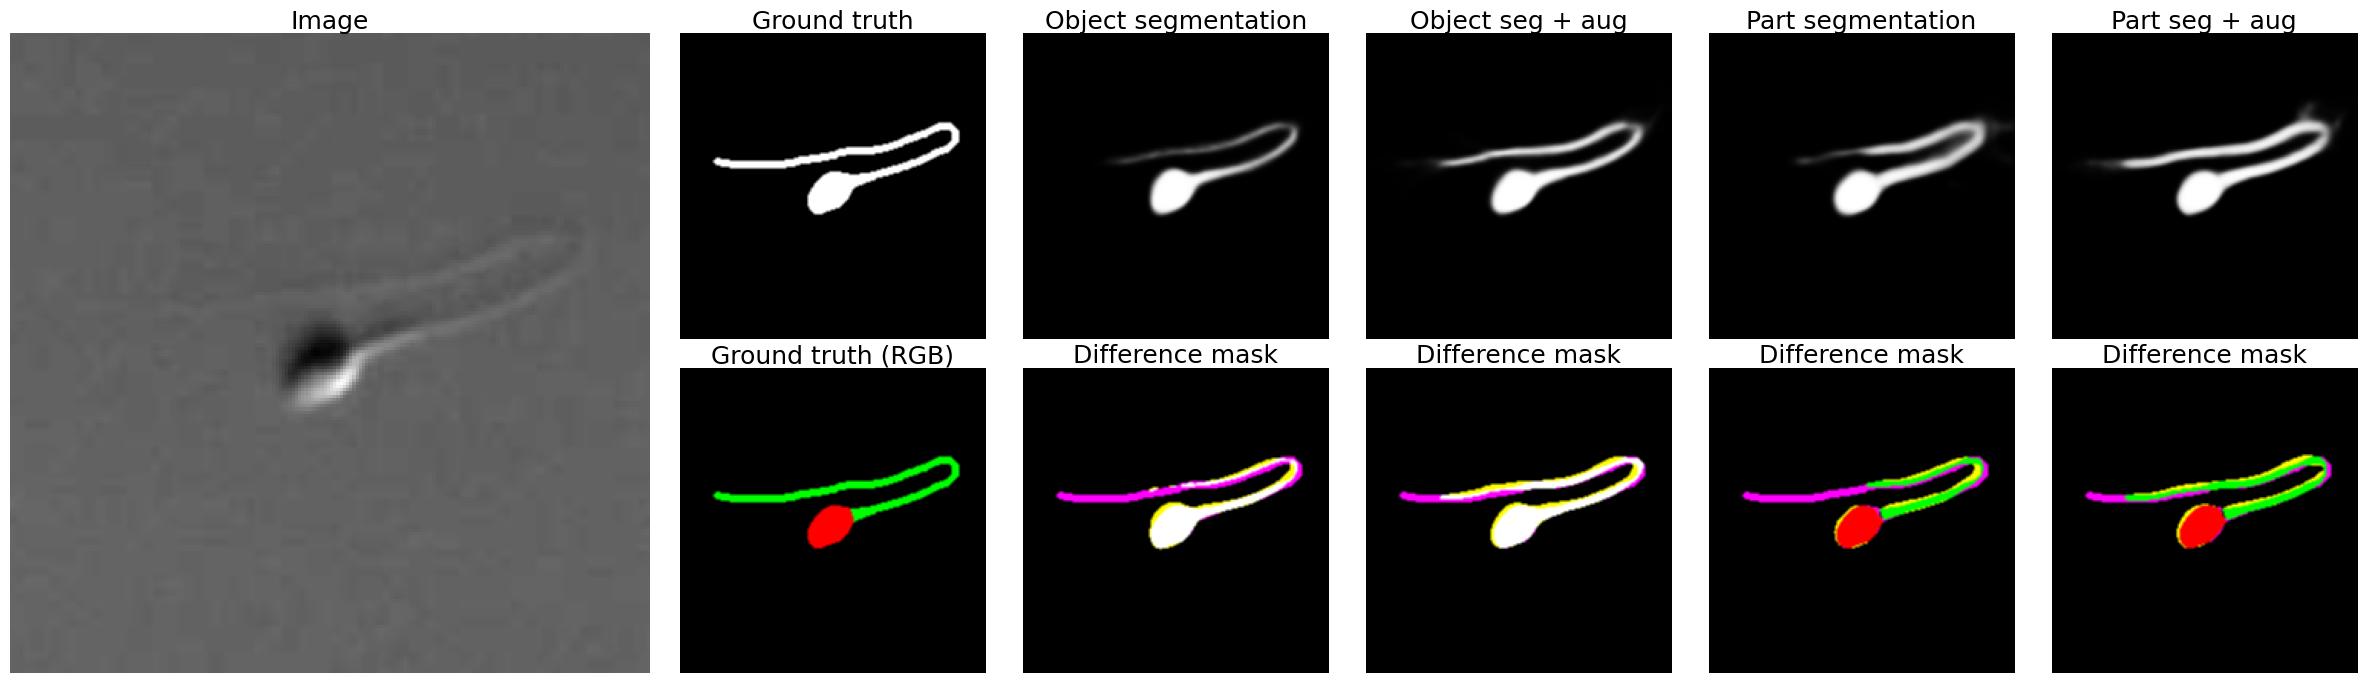

In [38]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Wczytaj wszystkie zdjęcia



def generate_difference_mask(gt_image_path, predicted_mask_path):
    # Wczytaj obrazy GT i maski przewidywanej przez model
    gt_image = cv2.imread(gt_image_path, cv2.IMREAD_GRAYSCALE)
    predicted_mask = cv2.imread(predicted_mask_path, cv2.IMREAD_GRAYSCALE)

    # Inicjalizuj pustą maskę różnic
    difference_mask = np.zeros((gt_image.shape[0], gt_image.shape[1], 3), dtype=np.uint8)

    # TP - obszary, które są poprawnie sklasyfikowane jako obiekty
    difference_mask[(gt_image == 255) & (predicted_mask == 255)] = [255, 255, 255]  # Biały

    # FP - obszary, które są błędnie sklasyfikowane jako obiekty
    difference_mask[(gt_image == 0) & (predicted_mask == 255)] = [255, 255, 0]  # Jasnoniebieski

    # FN - obszary, które są błędnie sklasyfikowane jako tło
    difference_mask[(gt_image == 255) & (predicted_mask == 0)] = [255, 0, 255]  # Fioletowy

    # TN - obszary, które są poprawnie sklasyfikowane jako tło
    difference_mask[(gt_image == 0) & (predicted_mask == 0)] = [0, 0, 0]  

    return difference_mask


def generate_difference_mask2(gt_image_path, predicted_mask_path):
      # Wczytaj obrazy GT i maski przewidywanej przez model
    gt_image = cv2.imread(gt_image_path)
    predicted_mask = cv2.imread(predicted_mask_path)

    # Inicjalizuj pustą maskę różnic
    difference_mask = np.zeros(gt_image.shape, dtype=np.uint8)

    # TP, FP, FN, TN dla klasy czerwonej (wici)
    # TP - obszary, które są poprawnie sklasyfikowane jako obiekty (czerwone)
    tp_red_mask = np.all(predicted_mask == [0, 0, 255], axis=-1) & np.all(gt_image == [0, 0, 255], axis=-1)
    difference_mask[tp_red_mask] = [255, 0, 0]  # Czerwony (TP wici)

    # FP - obszary, które są błędnie sklasyfikowane jako obiekty (czerwone)
    fp_red_mask = np.all(predicted_mask == [0, 0, 255], axis=-1) & np.all(gt_image == [0, 0, 0], axis=-1)
    difference_mask[fp_red_mask] = [255, 255, 0]  # Zielony (FP wici)

    # # FN - obszary, które są błędnie sklasyfikowane jako tło (czerwone)
    fn_red_mask = np.all(predicted_mask == [0, 0, 0], axis=-1) & np.all(gt_image == [0, 0, 255], axis=-1)
    difference_mask[fn_red_mask] = [255, 0, 255]  # Niebieski (FN wici)
    # 
    # # TN - obszary, które są poprawnie sklasyfikowane jako tło (czerwone)
    tn_red_mask = np.all(predicted_mask != [0, 0, 255], axis=-1) & np.all(gt_image != [0, 0, 255], axis=-1)
    difference_mask[tn_red_mask] = [0, 0, 0]  # Czarny (TN wici)




    # # TP, FP, FN, TN dla klasy zielonej (główka)
    # # TP - obszary, które są poprawnie sklasyfikowane jako obiekty (zielone)
    tp_green_mask = np.all(predicted_mask == [0, 255, 0], axis=-1) & np.all(gt_image == [0, 255, 0], axis=-1)
    difference_mask[tp_green_mask] = [0, 255, 0]  # Zielony (TP główka)

    # # FP - obszary, które są błędnie sklasyfikowane jako obiekty (zielone)
    fp_green_mask = np.all(predicted_mask == [0, 255, 0], axis=-1) & np.all(gt_image == [0, 0, 0], axis=-1)
    difference_mask[fp_green_mask] = [255, 255, 0]  # Czerwony (FP główka)
    # 
    # # FN - obszary, które są błędnie sklasyfikowane jako tło (zielone)
    fn_green_mask = np.all(predicted_mask == [0, 0, 0], axis=-1) & np.all(gt_image == [0, 255, 0], axis=-1)
    difference_mask[fn_green_mask] = [255, 0, 255]  # Niebieski (FN główka)

    # # TN - obszary, które są poprawnie sklasyfikowane jako tło (zielone)
    tn_green_mask = np.all(predicted_mask == [0, 0, 0], axis=-1) & np.all(gt_image == [0, 0, 0], axis=-1)
    difference_mask[tn_green_mask] = [0, 0, 0]  # Czarny (TN główka)

    return difference_mask



number = 67
crop_width, crop_height = 200, 200

image_paths = [f"/media/cal314-1/9E044F59044F3415/Marcin/noisy_labels/Dataset/SegSperm/test/For testing/images/{number}.png",
               
               f"/media/cal314-1/9E044F59044F3415/Marcin/noisy_labels/Dataset/SegSperm/test/For testing/GT/{number}.png", 
               
               f"/media/cal314-1/9E044F59044F3415/Marcin/results/Emilia_Annotator_1_Model_smpUNet++_Augmentation_True_Modeoneclass_Optimizer_Adam_Scheduler_CosineAnnealingLR_Epochs_200_Batch_Size_6_Start_lr_0.001_Loss_CrossEntropyLoss_Timestamp_2024-04-20-19-01_best_model_ap_oneclass_/{number}.png", 
               
               f"/media/cal314-1/9E044F59044F3415/Marcin/results/Marcin_Annotator_1_Model_smpUNet++_Augmentation_True_Modeoneclass_Optimizer_Adam_Scheduler_CosineAnnealingLR_Epochs_300_Batch_Size_6_Start_lr_0.001_Loss_CrossEntropyLoss_Timestamp_2024-04-27-18-20_best_model_iou_oneclass_/{number}.png",
               
               f"/media/cal314-1/9E044F59044F3415/Marcin/results/Emilia_Annotator_1_Model_smpUNet++_Augmentation_True_Modemulticlass_Optimizer_Adam_Scheduler_CosineAnnealingLR_Epochs_200_Batch_Size_6_Start_lr_0.001_Loss_CrossEntropyLoss_Timestamp_2024-04-21-16-30_best_model_ap_oneclass_/multiclass/{number}.png",
               
               f"/media/cal314-1/9E044F59044F3415/Marcin/results/Marcin_Annotator_1_Model_smpUNet++_Augmentation_True_Modemulticlass_Optimizer_Adam_Scheduler_CosineAnnealingLR_Epochs_300_Batch_Size_6_Start_lr_0.001_Loss_CrossEntropyLoss_Timestamp_2024-04-27-18-20_best_model_iou_multiclass_/multiclass/{number}.png"
               
               
               ]


mask_paths = [
                f"/media/cal314-1/9E044F59044F3415/Marcin/noisy_labels/Dataset/SegSperm/test/For testing/images/{number}.png",
               
               f"/media/cal314-1/9E044F59044F3415/Marcin/noisy_labels/Dataset/SegSperm/test/For testing/GT_merge/{number}.png", 
               
               f"/media/cal314-1/9E044F59044F3415/Marcin/results/Emilia_Annotator_1_Model_smpUNet++_Augmentation_True_Modeoneclass_Optimizer_Adam_Scheduler_CosineAnnealingLR_Epochs_200_Batch_Size_6_Start_lr_0.001_Loss_CrossEntropyLoss_Timestamp_2024-04-20-19-01_best_model_ap_oneclass_/masks/best_tresholds_oneclass/{number}.png", 
               
               f"/media/cal314-1/9E044F59044F3415/Marcin/results/Marcin_Annotator_1_Model_smpUNet++_Augmentation_True_Modeoneclass_Optimizer_Adam_Scheduler_CosineAnnealingLR_Epochs_300_Batch_Size_6_Start_lr_0.001_Loss_CrossEntropyLoss_Timestamp_2024-04-27-18-20_best_model_iou_oneclass_/masks/best_tresholds_oneclass/{number}.png",
               
               f"/media/cal314-1/9E044F59044F3415/Marcin/results/Emilia_Annotator_1_Model_smpUNet++_Augmentation_True_Modemulticlass_Optimizer_Adam_Scheduler_CosineAnnealingLR_Epochs_200_Batch_Size_6_Start_lr_0.001_Loss_CrossEntropyLoss_Timestamp_2024-04-21-16-30_best_model_ap_oneclass_/masks/best_tresholds_multiclass/{number}.png",
               
               f"/media/cal314-1/9E044F59044F3415/Marcin/results/Marcin_Annotator_1_Model_smpUNet++_Augmentation_True_Modemulticlass_Optimizer_Adam_Scheduler_CosineAnnealingLR_Epochs_300_Batch_Size_6_Start_lr_0.001_Loss_CrossEntropyLoss_Timestamp_2024-04-27-18-20_best_model_iou_multiclass_/masks/best_tresholds_multiclass/{number}.png"
               
               
               ]

images = [cv2.imread(img_path) for img_path in image_paths]
masks = [cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) for mask_path in mask_paths]

# Ustaw siatkę o wymiarach 2x3 z większym polem dla pierwszego zdjęcia
fig = plt.figure(figsize=(24, 7))
gs = gridspec.GridSpec(2, 6, width_ratios=[2, 1, 1,1,1,1], height_ratios=[0.9, 0.9])

# Ustaw pierwsze zdjęcie na większej części w siatce
plt.rcParams['font.size'] = 15
ax0 = plt.subplot(gs[:, 0])
if images:
    
    center_x = 185
    center_y = 218
    img = cv2.imread(image_paths[0], cv2.COLOR_BGR2RGB)
    crop_img = cv2.getRectSubPix(img, (crop_width, crop_height), (center_x, center_y))
    ax0.imshow(crop_img)
    ax0.set_title("Image", loc='center', pad=-10)
    ax0.axis('off')

    

    # Ustaw pozostałe zdjęcia w pierwszym wierszu
    for i in range(1, min(len(images), 6)):
        ax = plt.subplot(gs[0, i])
        img = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
        crop_img = cv2.getRectSubPix(img, (crop_width, crop_height), (center_x, center_y))
        ax.imshow(crop_img)
        
        if i == 1:
            ax.set_title(f"Ground truth", loc='center', pad=-10)
        elif i == 2:
            ax.set_title(f"Object segmentation", loc='center', pad=-10)
        elif i == 3:
            ax.set_title(f"Object seg + aug", loc='center', pad=-10)
        elif i == 4:
            ax.set_title(f"Part segmentation", loc='center', pad=-10)
        elif i == 5:
            ax.set_title(f"Part seg + aug", loc='center', pad=-10)
        #ax.set_title(f"Obraz {i}", loc='center', pad=10)
        ax.axis('off')

    # Ustaw pozostałe zdjęcia w drugim wierszu
    for i in range(1, min(len(images), 6)):
        ax = plt.subplot(gs[1, i])
        
        if i == 4 or i == 5:
            masks[i] = rgb_to_binary_mask(mask_paths[i])
            difference_mask = generate_difference_mask2(mask_paths[1], mask_paths[i])
            crop_img = cv2.getRectSubPix(difference_mask, (crop_width, crop_height), (center_x, center_y))
            ax.imshow(crop_img)
        else:
            masks[i] = cv2.cvtColor(masks[i], cv2.COLOR_BGR2RGB)
            if i == 1:
                image = cv2.imread(mask_paths[i])
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                crop_img = cv2.getRectSubPix(image_rgb, (crop_width, crop_height), (center_x, center_y))
                ax.imshow(crop_img)
            else:
                difference_mask = generate_difference_mask(image_paths[1], mask_paths[i])
                crop_img = cv2.getRectSubPix(difference_mask, (crop_width, crop_height), (center_x, center_y))
                ax.imshow(crop_img)
       
        if i == 1:
            ax.set_title(f"Ground truth (RGB)", loc='center', pad=-10)
        elif i == 2:
            ax.set_title(f"Difference mask", loc='center', pad=-10)
        elif i == 3:
            ax.set_title(f"Difference mask", loc='center', pad=-10)
        elif i == 4:
            ax.set_title(f"Difference mask", loc='center', pad=-10)
        elif i == 5:
            ax.set_title(f"Difference mask", loc='center', pad=-10)
        ax.axis('off')

    # Wyświetl siatkę
    plt.tight_layout()
    plt.savefig(f"/media/cal314-1/9E044F59044F3415/Marcin/results/compare_{number}.png")
    plt.show()
    
else:
    print("Brak poprawnie wczytanych obrazów do wyświetlenia.")



In [ ]:
# Przykładowe użycie funkcji
gt_image_path = "/media/cal314-1/9E044F59044F3415/Marcin/noisy_labels/Dataset/SegSperm/test/For testing/GT/0.png"
predicted_mask_path = "/media/cal314-1/9E044F59044F3415/Marcin/results/Marcin_Annotator_1_Model_smpUNet++_Augmentation_True_Modemulticlass_Optimizer_Adam_Scheduler_CosineAnnealingLR_Epochs_300_Batch_Size_6_Start_lr_0.001_Loss_CrossEntropyLoss_Timestamp_2024-04-27-18-20_best_model_iou_multiclass_/masks/best_tresholds_oneclass/0.png"
difference_mask = generate_difference_mask(gt_image_path, predicted_mask_path)

plt.imshow(difference_mask)
plt.axis('off')
plt.show()
